# Exercise Set 15: Text Classification and Sentiment Analysis

*Morning, August 21, 2019*

In this Exercise Set you will practice using two basic text classification methods: rule- and machine learning-based. The exercise has XX parts:

1. Implement a lexical look-up method.
2. Apply pre-packaged rulebased dictionaries.
3. Train a simple baseline machine learning classifier.

In the end, you will then compare the results of these approaches.

First, load our standard stuff and import the following modules:

In [44]:
import names
nltk.download('names')
import nltk
name=nltk.corpus.names

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\frede\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\names.zip.


In [59]:
name.fileids()
name.words('male.txt') in name.words('female.txt')
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3
check=intersection(name.words('male.txt'),name.words('female.txt'))
check

['Abbey',
 'Abbie',
 'Abby',
 'Addie',
 'Adrian',
 'Adrien',
 'Ajay',
 'Alex',
 'Alexis',
 'Alfie',
 'Ali',
 'Alix',
 'Allie',
 'Allyn',
 'Andie',
 'Andrea',
 'Andy',
 'Angel',
 'Angie',
 'Ariel',
 'Ashley',
 'Aubrey',
 'Augustine',
 'Austin',
 'Averil',
 'Barrie',
 'Barry',
 'Beau',
 'Bennie',
 'Benny',
 'Bernie',
 'Bert',
 'Bertie',
 'Bill',
 'Billie',
 'Billy',
 'Blair',
 'Blake',
 'Bo',
 'Bobbie',
 'Bobby',
 'Brandy',
 'Brett',
 'Britt',
 'Brook',
 'Brooke',
 'Brooks',
 'Bryn',
 'Cal',
 'Cam',
 'Cammy',
 'Carey',
 'Carlie',
 'Carlin',
 'Carmine',
 'Carroll',
 'Cary',
 'Caryl',
 'Casey',
 'Cass',
 'Cat',
 'Cecil',
 'Chad',
 'Chris',
 'Chrissy',
 'Christian',
 'Christie',
 'Christy',
 'Clair',
 'Claire',
 'Clare',
 'Claude',
 'Clem',
 'Clemmie',
 'Cody',
 'Connie',
 'Constantine',
 'Corey',
 'Corrie',
 'Cory',
 'Courtney',
 'Cris',
 'Daffy',
 'Dale',
 'Dallas',
 'Dana',
 'Dani',
 'Daniel',
 'Dannie',
 'Danny',
 'Darby',
 'Darcy',
 'Darryl',
 'Daryl',
 'Deane',
 'Del',
 'Dell',
 'Deme

In [5]:
import requests,os,time
def ratelimit():
    "A function that handles the rate of your calls."
    time.sleep(1) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit()
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
    else:
      t = time.time()
      ratelimit()
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return call_id
logfile = 'log opgave 15'## name your log file.
connector = Connector(logfile)

In [150]:
## Standard stuff:
import numpy as np, seaborn as sns, pandas as pd
## For text classification:
import nltk, nltk.sentiment, sklearn
%matplotlib inline

## Exercise 15 Part 1: Implementing your own Lexical Lookup method
There are many curated dictionaries and lexicons online for all sorts of topics (see for instance this project: https://hedonometer.org/index.html where the lexicons behind it can be downloaded here: https://github.com/andyreagan/hedonometer/blob/master/hedonometer/static/hedonometer/labMT1.txt). For this exercise we will use the following list of positive and negative words (positive:http://ptrckprry.com/course/ssd/data/negative-words.txt ; negative: http://ptrckprry.com/course/ssd/data/positive-words.txt) compilled by Hu and Liu. 

We will use the following dataset (a random sample of the trustpilot review data we collected in exercise 8) to practice on.

> **Ex. 15.1.1:**  Load it like this (remember to import the `request` package): 

```python 
# download data
path2data = 'https://raw.githubusercontent.com/snorreralund/scraping_seminar/master/english_review_sample.csv'
df = pd.read_csv(path2data)```

The important columns are ***reviewBody*** containing the text, and the ***reviewRating_ratingValue*** containing the rating / stars.

In [4]:
import requests

path2data = 'https://raw.githubusercontent.com/snorreralund/scraping_seminar/master/english_review_sample.csv'
df = pd.read_csv(path2data)
df.head()

,Unnamed: 0,__domain__,address_@type,address_addressCountry,address_addressLocality,address_postalCode,address_streetAddress,author_@type,datePublished,email,...,inLanguage,itemReviewed_@type,itemReviewed_name,meta_@type,name,reviewBody,reviewRating_@type,reviewRating_ratingValue,telephone,categories
0,159770,https://trustpilot.com/review/www.exmed.net,PostalAddress,NaN,Fenton,63026,218 Seebold Spur,Person,2017-07-29T20:27:03Z,sales@exmed.net,...,en,Thing,Express Medical Supply,LocalBusiness,Express Medical Supply,"Lots of inventory, very fast and efficient. I ...",Rating,5,(800) 633-2139,/health_wellbeing
1,168724,https://trustpilot.com/review/mapscompany.com,PostalAddress,NaN,"Petit-Rocher, NB",E8J 1E4,713 rue de la Mer,Person,2017-08-11T20:09:48Z,contact@mapscompany.com,...,en,Thing,MapsCompany,LocalBusiness,MapsCompany,I did not received the map I had ordered and p...,Rating,3,NaN,/travel_holidays
2,96443,https://trustpilot.com/review/www.thriftbooks.com,PostalAddress,NaN,Tukwila,98188,"18300 Cascade Ave S, Ste 150",Person,2015-03-19T22:59:22Z,reviews@thriftbooks.com,...,en,Thing,Thrift Books,LocalBusiness,Thrift Books,After searching a number of stores here in my ...,Rating,5,253-275-2251,/entertainment
3,173433,https://trustpilot.com/review/fabletics.com,PostalAddress,NaN,NaN,NaN,NaN,Person,2017-04-30T19:47:39Z,NaN,...,en,Thing,Fabletics,LocalBusiness,Fabletics,Website is not intuitive. I don't like having...,Rating,2,855-202-3570,/clothes_fashion
4,138968,https://trustpilot.com/review/www.enterprise.com,PostalAddress,US,St Louis,63105,600 Corporate Park Dr,Person,2018-05-26T20:43:41Z,NaN,...,en,Thing,Enterprise,LocalBusiness,Enterprise,"Outstanding customer service, appreciated the ...",Rating,5,NaN,/transportation


> **Ex. 15.1.2:** Next, we should download and prepare the dictionaries.
1. Download the lists using python's `requests.get()`. The lists are documents of words separated by new line (which is the '\n' character). 
2. Make sure to remove the comment section in the top by splitting at the right place. 
3. `.split()` these documents into words.
4. Convert them into sets (using the `set()`-command) and assign these to two variables (e.g. ***positive*** and ***negative***). 

*Hint*: You can do all of the above in one line of code per list.

In [12]:
pos_url='http://ptrckprry.com/course/ssd/data/positive-words.txt'
neg_url='http://ptrckprry.com/course/ssd/data/negative-words.txt'
response_pos,call_id = connector.get(pos_url,'Postive')
response_neg,call_id = connector.get(neg_url,'Postive')
pos=response_pos.text
neg=response_neg.text


In [74]:
pos_word=pos.split(';;;;;;')[24].split('\n')[2:-1]
neg_word=neg.split(';;;;;;')[26].split('\n')[2:-1]

positive=set(pos_word)
negative=set(neg_word)


Now we need to prepare the trustpilot reviews, our documents to be analyzed. This means lowercasing and tokenizing them to match the format that our dictionary comes in.

> **Ex. 15.1.3:** Define a function `preprocessing(string)`, that takes in a string and returns a list of words. The function should do the following: 
1. lowercases the string using the `.lower()` command.
2. tokenize the words using the `nltk.tokenize.TweetTokenizer()` which is good for social media type user content (i.e. emojiies and more free use of punctuation and commas. 
3. return tokenized documents.

*Hint*: You can first initialize the tokenizer (outside the preprocessing function), and then you use the `.tokenize()` method.

In [109]:
rev=str(df['reviewBody'])
tokenizer = nltk.tokenize.TweetTokenizer()

def preprocessing(string):
    lower=string.lower()
    token=tokenizer.tokenize(lower)
    return token
preprocessing('sIndzYgt jO c00l :)!!!!')

['sindzygt', 'jo', 'c00l', ':)', '!', '!', '!']

>**Ex 15.1.4:** Apply the preprocessing function to all the documents (i.e. our review texts in the column ***reviewBody***).

*Hint:* Use the `.apply()` method.

In [119]:
docs=df['reviewBody'].apply(preprocessing)

Now, we need to match the words in our dictionaries to the tokenized documents.
>**Ex 15.1.5:** Define a function `count_dictionary(document,dictionary)` that takes a tokenized document and a set of words (i.e. the dictionaries we loaded in Ex 15.1.2) and counts the number of matches. The function should do the following:
1. Filter the words not in the dictionary. 
*Hint*: you can use a list comprehension or for loop and `if word in` condition. 
2. Return the length of the filtered document.			

In [140]:
def count_dictionary(doc,dic):
    doc_new=[ x for x in doc if x in dic]
    return len(doc_new)
count_dictionary(docs[11],positive)

1

>**Ex 15.1.6:** Define two new columns (***positive_liu***, ***negative_liu***) in the dataframe applying the count_dictionary function to all tokenized documents with the positive and negative set as input. 

*Hint:* the `.apply()` method allows you to input named arguments matching your `count_dictionary()` function to input the sentiment dictionary. 

In [157]:
df['Positive_liu']=df['reviewBody'].apply(preprocessing).apply(count_dictionary, dic=positive)
df['Negative_liu']=df['reviewBody'].apply(preprocessing).apply(count_dictionary, dic=negative)
df.head()

,Unnamed: 0,__domain__,address_@type,address_addressCountry,address_addressLocality,address_postalCode,address_streetAddress,author_@type,datePublished,email,...,itemReviewed_name,meta_@type,name,reviewBody,reviewRating_@type,reviewRating_ratingValue,telephone,categories,Positive_liu,Negative_liu
0,159770,https://trustpilot.com/review/www.exmed.net,PostalAddress,NaN,Fenton,63026,218 Seebold Spur,Person,2017-07-29T20:27:03Z,sales@exmed.net,...,Express Medical Supply,LocalBusiness,Express Medical Supply,"Lots of inventory, very fast and efficient. I ...",Rating,5,(800) 633-2139,/health_wellbeing,3,0
1,168724,https://trustpilot.com/review/mapscompany.com,PostalAddress,NaN,"Petit-Rocher, NB",E8J 1E4,713 rue de la Mer,Person,2017-08-11T20:09:48Z,contact@mapscompany.com,...,MapsCompany,LocalBusiness,MapsCompany,I did not received the map I had ordered and p...,Rating,3,NaN,/travel_holidays,3,2
2,96443,https://trustpilot.com/review/www.thriftbooks.com,PostalAddress,NaN,Tukwila,98188,"18300 Cascade Ave S, Ste 150",Person,2015-03-19T22:59:22Z,reviews@thriftbooks.com,...,Thrift Books,LocalBusiness,Thrift Books,After searching a number of stores here in my ...,Rating,5,253-275-2251,/entertainment,5,0
3,173433,https://trustpilot.com/review/fabletics.com,PostalAddress,NaN,NaN,NaN,NaN,Person,2017-04-30T19:47:39Z,NaN,...,Fabletics,LocalBusiness,Fabletics,Website is not intuitive. I don't like having...,Rating,2,855-202-3570,/clothes_fashion,4,0
4,138968,https://trustpilot.com/review/www.enterprise.com,PostalAddress,US,St Louis,63105,600 Corporate Park Dr,Person,2018-05-26T20:43:41Z,NaN,...,Enterprise,LocalBusiness,Enterprise,"Outstanding customer service, appreciated the ...",Rating,5,NaN,/transportation,3,0


> **Ex 15.1.7 (BONUS):** Define your own set of words and use the count_dictionary function to match them (remember that they need to be lowercased to match).

In [14]:
# [Answer Ex 15.1.7]

### Exercise 15 Part 2: Applying prepackaged rulebased dictionaries and comparison of results
In the following exercise you will apply two prepackaged dictionaries which are also rulebased. One is MIT's VADER method (https://github.com/cjhutto/vaderSentiment) which is builtin to the NLTK package, and the Finn Aarups (DTU) AFINN sentiment analyzer, which has the advantage of working on danish text. 


>**Ex 15.2.1:** Apply VADER: Define a four new columns using output from the VADER sentiment analyzer 
1. Import the `nltk`, `nltk.sentiment` package and download the vader_lexicon using `nltk.download('vader_lexicon')`.
2. Initialize the the vader sentiment analyzer: nltk.sentiment.vader.SentimentIntensityAnalyzer()
3. Apply the `.polarity_scores` function to all documents. This function should be provided with a string. So, you do not need to tokenize the documents, but instead you can just use the ***reviewBody*** column of your dataframe.
4. Convert the resulting Series of dictionaries (Vader outputs dictionaries of 4 scores) to a dataframe by first converting the Series into a list using the `list()` function, and then the `pd.DataFrame()` function.
5. Rename the columns adding vader_ as prefix.
6. Merge with original Dataframe. 

*Hint:* Use `pd.concat([df,df2],axis=1)` 


In [159]:
nltk.download('vader_lexicon')
vader=nltk.sentiment.vader.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\frede\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [172]:
bob=df['reviewBody'].apply(vader.polarity_scores)
bob_2=list(bob)
df[['vader_compound','vader_neg','vader_neu','vader_pos']]=pd.DataFrame(bob_2)


>**Ex 15.2.2:** Install the AFINN package: `pip install afinn`. Read how to apply the afinn package here (https://github.com/fnielsen/afinn) and define a column called afinn. 

*Hint:* As VADER's `polarity_score`, AFINN should be provided with a string and not the tokenized documents.

In [178]:
from afinn import Afinn
afinn = Afinn()
df['afinn']=df['reviewBody'].apply(afinn.score)


>**Ex 15.2.3:** Plot all the different dictionary and rulebased sentiment analysis columns against each other using the seaborn plotting function `sns.pairplot`. Set the color (i.e. hue argument as the number of stars in the `reviewRating_ratingValue` column). 

*Hint:* To plot, work with a smaller dataframe. You shoul select only the relevant columns, i.e. the ones with the sentiment analysis results and the star rating column. Moreover, you can downsample the dataframe to 1000 rows using the `.sample()` method.


C:\Users\frede\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\frede\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


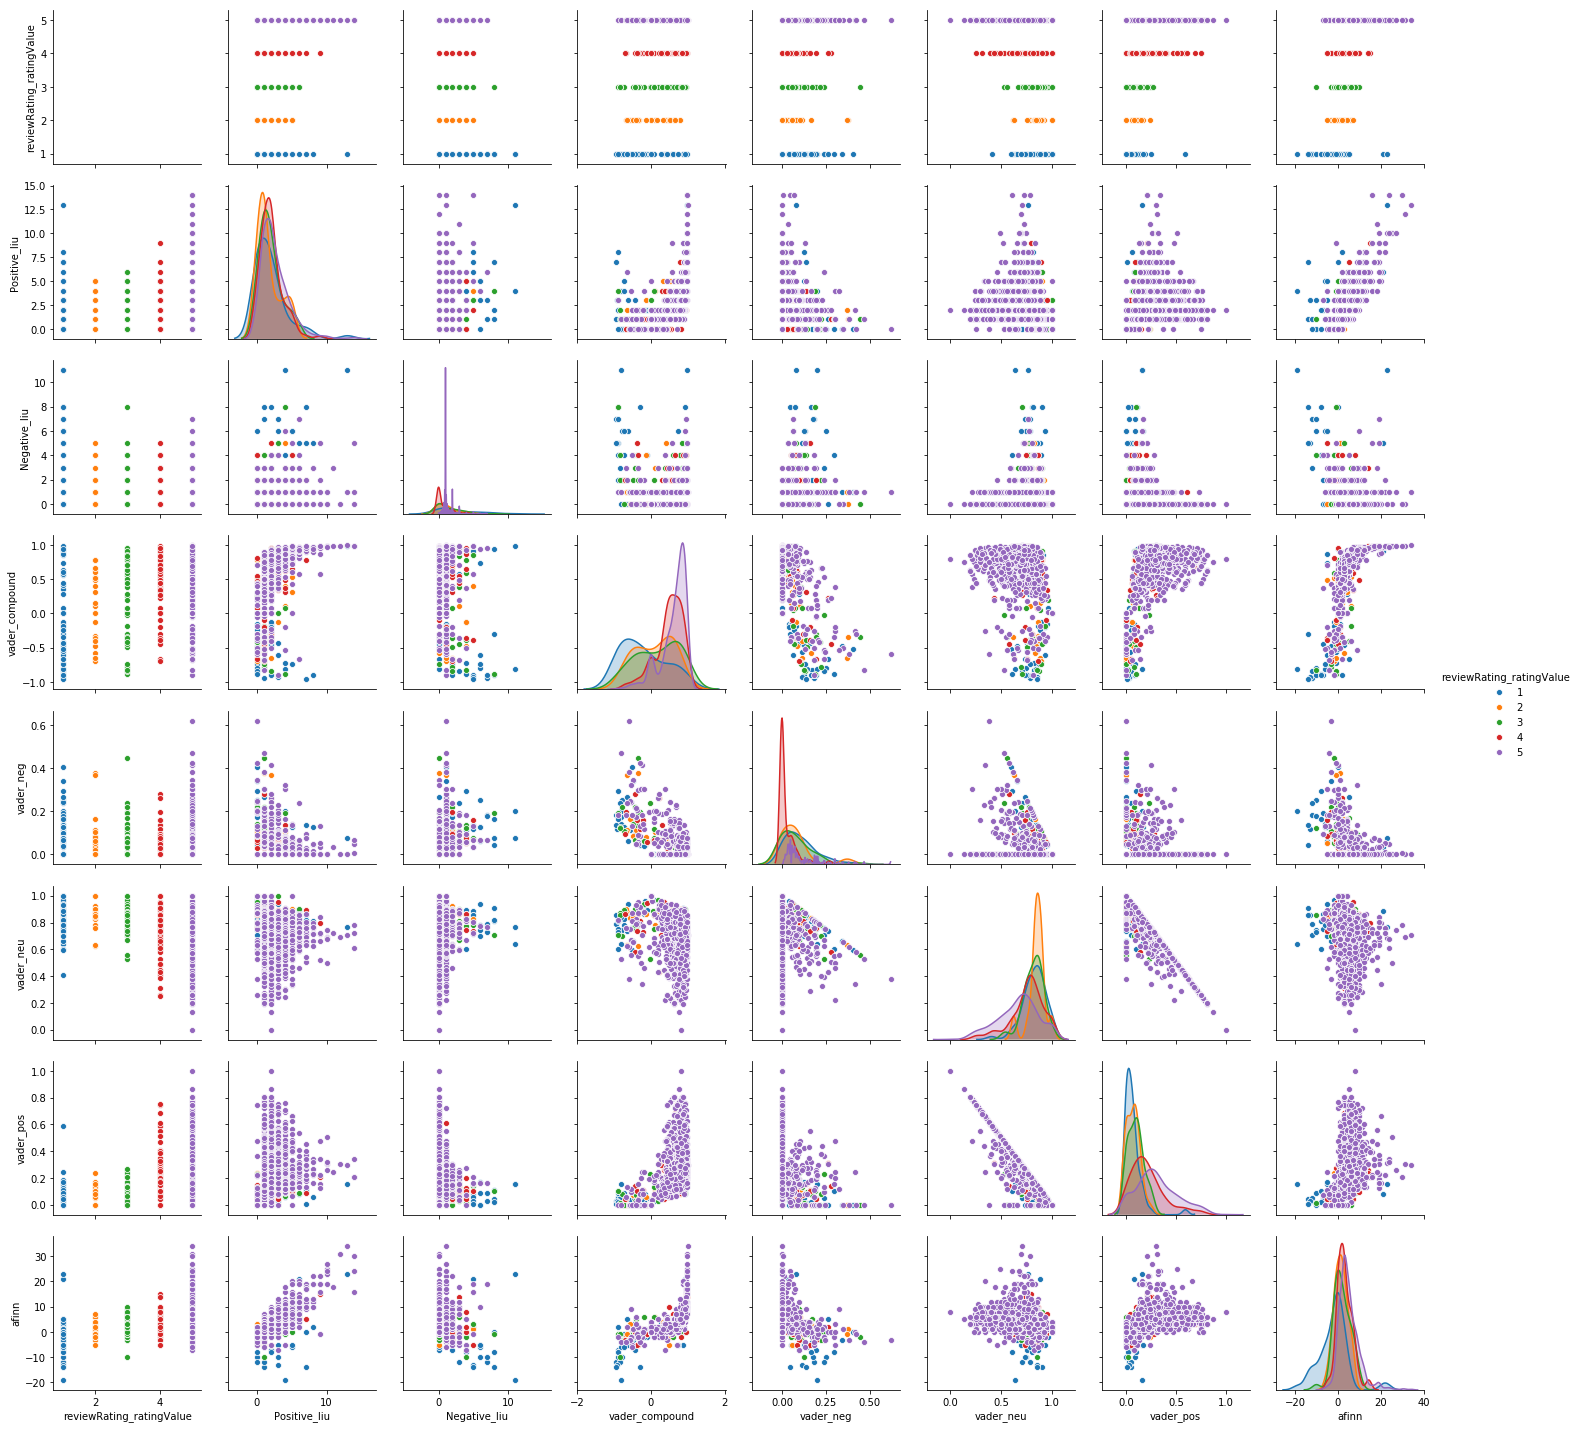

In [186]:
df_done=df[['reviewRating_ratingValue','Positive_liu','Negative_liu','vader_compound','vader_neg','vader_neu','vader_pos','afinn']]
df_sample=df_done.sample(1000)
sns.pairplot(df_sample, hue='reviewRating_ratingValue')

>**Ex 15.2.4:** Inspect a document where the LIU and VADER dictionaries disagree. More specifically, look at documents where the LIU lexicon is positive and the VADER is negative. For that, you should filter on positive expressions by LIU, and sample in the most negative according to the VADER. Try to explain the disagreement in terms of simple matches versus negations. 

*Hint*: Pick a document and see which words the LIU lexicon has matched using python set notation: e.g. 

```python 
# overlap between two sets
set(documents[0])&positive
```

In [237]:
df_filter=df.drop(df_done[df_done.Positive_liu==0].index)
df_filter.sort_values(by=['vader_compound'])
set(docs[7682])&positive
# docs[7682]

{'cheaper', 'correct', 'correctly', 'refund', 'right'}

## Exercise 15 Part 3: Train a classifier to score the reviews and compare results
In following exercise you will implement a simple text classifier based on the logistic regression trained on the ratings. We will walk through the standard procedures of Supervised Learning - i.e. parameter search and crossvalidation - but first we need to transform our documents into feature vectors. Here, we will use the sklearn function `sklearn.feature_extraction.text.CountVectorizer`. This module will transform the documents into BoWs (bag of words), using words counts and combinations of words (i.e. ngram) as columns.

> **Ex 15.3.1:** Make a train-test (50-50) split before applying any transformation to avoid *data leakage* and to set up a clean hyperparameter search using the train set, and saving the test set for crossvalidation. 

*Hint:* Use `sklearn.model_selection.train_test_split`.


In [240]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from math import sqrt

y=df['reviewRating_ratingValue']
X=df.drop(columns='reviewRating_ratingValue')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

> **Ex 15.3.2:** Preproce the documents as in Ex 15.1.3. Then, initialize the `sklearn.feature_extraction.text.CountVectorizer`. 
The countvectorizer has many possible inputs: The important ones here are the tokenization function (use the one defined above, i.e. `tokenizer=tokenizer.tokenize`) and `ngram_range=(1,2)`. Finally, run the `.fit()` function with the train documents as input.

In [26]:
#[Answer Ex 15.3.2]

> **Ex 15.3.3:** Transform train and test documents to a sparse vector using the `transform` command on both the test and the train documents. Assign these to two variables, e.g. `X_train` and `X_test`. Afterwards, inspect the resulting dimensions of each input vector using the `.shape` function.

In [28]:
#[Answer Ex 15.3.3]

> **Ex 15.3.4:** Convert ratings to binary outcome. Here we make a decision to count ratings as positive if above 3 and otherwise negative. Define ***y_train*** and ***y_test*** as a binary variables expressing whether it is higher than 3 or not.

In [30]:
#[Answer Ex 15.3.4]

Now we are ready to train our model. We will use the penalized logistic regression which is widely used for training baseline in within natural language processing (NLP) - especially with a little twist see [Wang and Manning 2012](https://www.aclweb.org/anthology/P12-2018). 
As always we should we remember to do our parameter search using the training data only.

> **Ex 15.3.5:** In this case we will do only a search over the penalizationterm C and, therefore, we can use the `sklearn.linear_model.LogisticRegressionCV()` which handles kfold-based parameter search directly. The function takes as arguments the range of values to be searched and the number of folds used for cross-validation.

*Hint:* You can use a `LogisticRegressionCV()` with the arguments `Cs=np.linspace(0.1,2,10)`,`cv=10` and `verbose=2`. You can vary these arguments if you want.

In [32]:
# [Answer Ex 15.3.5]

> **Ex 15.3.6:** Report the performance of the classifier. You should report the accuracy. Additionally, you might want to report precision, recall, f1, AUC and roc-auc-curve.

*Hint:* These measures can be computed using the `sklearn.metrics` package. You might want to define a function that takes your classifier and data as input and returns the metrics.

In [ ]:
# [Answer Ex 15.3.6]

> **Ex 15.3.7:** Create a column in the dataframe applying the classifier to all documents.
1. First transform documents using vectorizer from before. 
2. Get the predicted probability of a positive review: `clf.predict_proba(X)`. Note that you only need the second column - it predicts probabilities for both classes 0 and 1.

In [35]:
# [Answer Ex 15.3.7]

>**Ex 15.3.8 (BONUS):** Compute the correlation of the computed sentiment with the given rating for all three methods. Would you expect a positive or a negative correlation? Note that there are different categories describing the ratings' subjects (see the ***categories*** column). You can compute the correlation averaging the ratings and the sentiment scores over these categories.

In [ ]:
# [Answer Ex 15.3.8 (BONUS)]